In [1]:
import sys
sys.path.append('/home/dim/projects/ml/friends/tv-series-scripts-generator')
sys.path.append('/home/dim/projects/ml/friends/tv-series-scripts-generator/text_generation')
import numpy as np
from corpus_preprocessing import utils
from character_choice import *
from text_generation import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
scenes = utils.load_scenes_from_folder('/home/dim/projects/ml/friends/tv-series-scripts-generator/raws')

In [4]:
filter_stage_directions(scenes)
scenes[0]

[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]
monica: There's nothing to tell! He's just some guy I work with!
joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!
chandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?
phoebe: Wait, does he eat chalk?
phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!
monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.
chandler: Sounds like a date to me.

In [5]:
character_to_id = generate_character_to_id_dict(scenes, 11)
character_to_id 

{'UNK_CHARACTER': 0,
 'END_CHARACTER': 1,
 'rachel': 2,
 'ross': 3,
 'monica': 4,
 'chandler': 5,
 'joey': 6,
 'phoebe': 7,
 'mike': 8,
 'all': 9,
 'richard': 10,
 'janice': 11,
 'mr. geller': 12}

In [10]:
tokenize_scenes(scenes)

In [11]:
scenes[0]

[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]
monica: there ' s nothing to tell ! he ' s just some guy i work with !
joey: c ' mon , you ' re going out with the guy ! there ' s gotta be something wrong with him !
chandler: all right joey , be nice . so does he have a hump ? a hump and a hairpiece ?
phoebe: wait , does he eat chalk ?
phoebe: just , ' cause , i don ' t want her to go through what i went through with carl - oh !
monica: okay , everybody relax . this is not even a date . it ' s just two people going out to dinner and - not having sex .
chandler: sounds like a date to me .

In [12]:
word_to_id = generate_word_to_id(generate_vocab(scenes))
id_to_word = generate_id_to_word(generate_vocab(scenes))

Text(0.5, 0, 'Number of tokens')

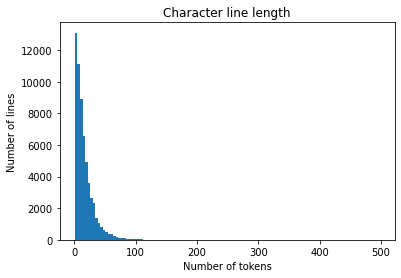

In [13]:
lines_lens = []
for scene in scenes:
    for action in scene.actions:
        lines_lens.append(len(action.line.split()))

plt.hist(lines_lens, bins=120)
plt.title('Character line length')
plt.ylabel('Number of lines')
plt.xlabel('Number of tokens')

In [14]:
data = generate_trainable_data(scenes, character_to_id, word_to_id)

In [15]:
data[0][-1], ids_to_words(data[0][-1][1], id_to_word)

((5,
  array([  0, 486,  61,  16, 299,  13,  33,   4,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1])),
 'sounds like a date to me .')

In [16]:
import tensorflow as tf
assert tf.__version__.startswith('2'), "Current tf version: {}; required: 2.0.*".format(tf.__version__)

In [17]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(data, test_size=0.3, random_state=42)

In [18]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

opt = keras.optimizers.Adam(1e-3)
batch_size = 32

In [19]:
scenes[0].actions

[monica: there ' s nothing to tell ! he ' s just some guy i work with !,
 joey: c ' mon , you ' re going out with the guy ! there ' s gotta be something wrong with him !,
 chandler: all right joey , be nice . so does he have a hump ? a hump and a hairpiece ?,
 phoebe: wait , does he eat chalk ?,
 phoebe: just , ' cause , i don ' t want her to go through what i went through with carl - oh !,
 monica: okay , everybody relax . this is not even a date . it ' s just two people going out to dinner and - not having sex .,
 chandler: sounds like a date to me .]

In [20]:
model = DialogueModel(10_000, 64, 64, 1)

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

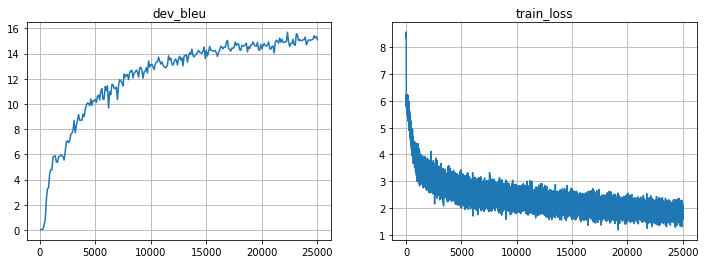

Mean loss=1.777


100%|██████████| 25000/25000 [6:07:07<00:00,  1.13it/s]


In [32]:
import random
random.seed(42)

for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = random.choice(train)
    batch_ix = np.array(list(map(lambda x: x[1], random.choice(train))))
    batch_inp = batch_ix[:-1]
    batch_out = batch_ix[1:]
    
    with tf.GradientTape() as tape:
         loss_t = loss_function(model(batch_inp), batch_out)
    
    grads = tape.gradient(loss_t, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    
    metrics['train_loss'].append((step, loss_t.numpy()))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [42]:
print('[Context] monica: okay , everybody relax . this is not even a date . it \' s just two people going out to dinner and - not having sex .')
k = predict_answer(model, 'monica', 'okay , everybody relax . this is not even a date . it \' s just two people going out to dinner and - not having sex .', 'chandler')

print('[Ground-Truth Response] chandler: sounds like a date to me .')
print(f'[Model Response] {k}')

[Context] monica: okay , everybody relax . this is not even a date . it ' s just two people going out to dinner and - not having sex .
[Ground-Truth Response] chandler: sounds like a date to me .
[Model Response] argh ! i can believe you did that .


# CCEDS (Cluster Chains Evaluation for Dialogue Systems)

1. We need to choose the character line vectorization algorithm: $V(x)$
 - bow/tf-idf
 - fasttext/w2v/glove
 - bert/elmo
 
2. We choose the clustering algorithm and cluster count: $C(V(x)), n$
 - K-Means
 - DBSCAN
 - EM Clustering
 
    The set of all clusters will be $C$

3. For all dataset we calculate the cluster sequences $P[C(V(x)) | prefix]$

    This is very similar with how we calculate the n-gram probabilities
    
    The set of all prefixes will be $Pr$
    
4. Now we can evaluate the answer:

    $\sum_{c \in C; p \in Pr;} cosine\_distance(V(x), c) \cdot P(c | prefix)$

5. For all dataset:

    $\sum_{x \in X;} \big( \sum_{c \in C; p \in Pr;} cosine\_distance(V(x), c) \cdot P(c | prefix) \big)$